<a href="https://colab.research.google.com/github/Andrei-WongE/ML_sandbox/blob/origin/Class_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REPRESENTATION LEARNING - AUTOENCODERS

In [1]:
#Need to first set up Colab’s runtime environment to use GPUs or TPUs instead of CPUs.
# select “Change runtime type” under “Runtime” from Colab’s menu bar.

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))


Found GPU at: /device:GPU:0


In [4]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
print(tf.__version__)

from __future__ import print_function
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

2.15.0


In [6]:
# Checking
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


import the mnist data and shape it:

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
print(x_train.shape)
print(x_test.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


Before we used to add layers using
the sequential API as follows:

```
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
```



## A Simple Autoencoder

In [ ]:
# With the functional API we do this:
layer_1 = Dense(16, activation='relu')(input)
layer_2 = Dense(8, activation='relu')(layer_1)

The output of Dense method is a
callable layer, using the functional API we provide it with the input and store the output. The output
of a layer becomes the input of the next layer. With the sequential API the add method implicitly
handled this for us.

In [11]:
# Function to implement our autoencoders
def auto_encoder_model(p_hidden_size=128, p_code_size=32, sparse=False, regval=10e-6):
  input_size = 784
  hidden_size = p_hidden_size
  code_size = p_code_size
  input_img = Input(shape=(input_size,))
  hidden_1 = Dense(hidden_size, activation='relu')(input_img)

  if sparse:
    code = Dense(code_size, activation='relu',
  activity_regularizer = l1(regval))(hidden_1)
  else:
    code = Dense(code_size, activation='relu')(hidden_1)
  hidden_2 = Dense(hidden_size, activation='relu')(code)
  output_img = Dense(input_size, activation='sigmoid')(hidden_2)

  autoencoder = Model(input_img, output_img)
  encoded = Model(input_img, code)

  return autoencoder, encoded

In [12]:
# generate an autoencoder model
autoencoder, _ = auto_encoder_model()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 8s 3ms/step - loss: 0.1398
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1009
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0953


visualize how well our autoencoder reconstructs its input

313/313 [==============================] - 0s 2ms/step


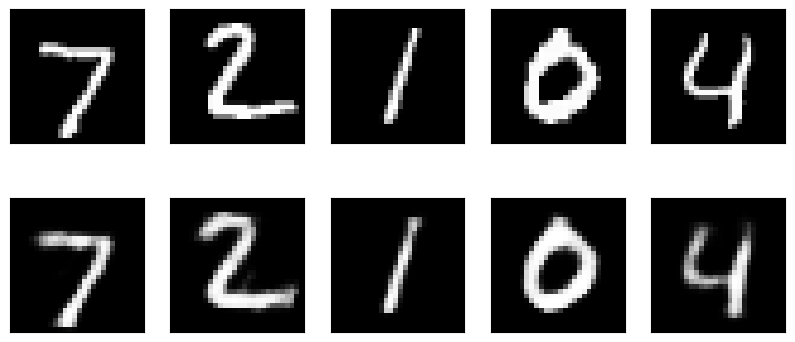

In [17]:
def plot_image_comparison(base_images, comparison_images, p_n = 5, dims=(28,28) ):
  decoded_imgs = autoencoder.predict(x_test)
  # number of example digits to show
  n = p_n
  plt.figure(figsize=(10, 4.5))
  for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(base_images[i].reshape(*dims))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if i == n/2:
      ax.set_title('Original Images')
    # plot reconstruction
    ax = plt.subplot(2, n, i + 1+ n)
    plt.imshow(comparison_images[i].reshape(*dims))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    if i == n/2:
      ax.set_title('Reconstructed Images')

plt.show()

plot_image_comparison(x_test, autoencoder.predict(x_test))

##Denoising Autoencoder

313/313 [==============================] - 0s 2ms/step


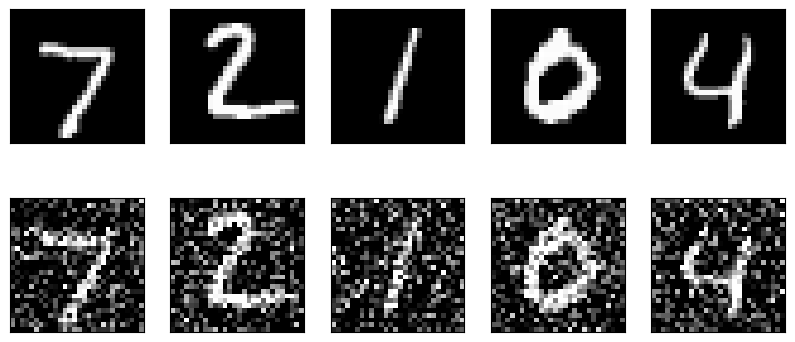

In [18]:
#Creating noisy input

noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)
plot_image_comparison(x_test, x_test_noisy)

If we let our previously trained autoencoder try to reproduce the images when given the noisy input,
we can see that it doesn’t do very well.

313/313 [==============================] - 1s 2ms/step


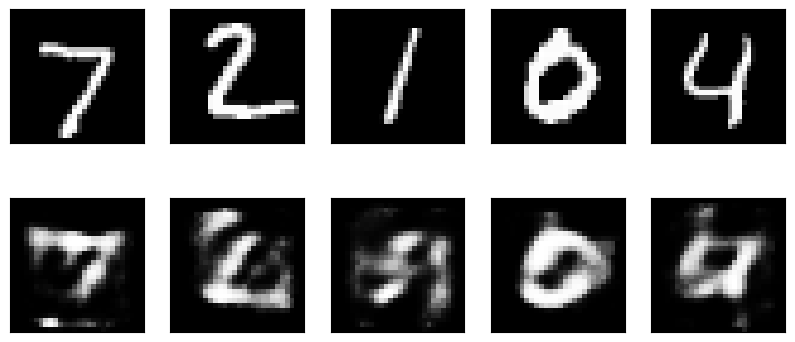

In [19]:
plot_image_comparison(x_test, autoencoder.predict(x_test_noisy))

To get a better fit we need to make one small difference between the implementation of denoising
autoencoder and the regular one. The architecture doesn’t change at all, only the fit function.

In [20]:
#Denoising autoencoder is trained as:
autoencoder.fit(x_train_noisy)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1152, in train_step
        self._validate_target_and_loss(y, loss)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1106, in _validate_target_and_loss
        raise ValueError(

    ValueError: Target data is missing. Your model was compiled with loss=binary_crossentropy, and therefore expects target data to be provided in `fit()`.
